General EDA

EDA inspired by 
https://ncss-tech.github.io/stats_for_soil_survey/book/eda.html 

In [1]:
#checking if i made a password

from sqlalchemy import create_engine

DB_NAME = "soils_angola"  # change this
USER = "inesschwartz"     # change this (often your OS username)
HOST = "localhost"
PORT = "5432"

# 1️⃣ Try without password (peer/local auth)
try:
    print("Trying connection without password...")
    engine = create_engine(f"postgresql://{USER}@{HOST}:{PORT}/{DB_NAME}")
    with engine.connect() as conn:
        print("✅ Connected successfully without a password.")
except Exception as e:
    print("❌ No-password connection failed:", e)

# 2️⃣ Try with password (change 'mypassword' if you know one)
try:
    print("\nTrying connection with password...")
    PASSWORD = "aa4862aa"  # put your password here if you think you have one
    engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}")
    with engine.connect() as conn:
        print("✅ Connected successfully with a password.")
except Exception as e:
    print("❌ Password connection failed:", e)


Trying connection without password...
✅ Connected successfully without a password.

Trying connection with password...
✅ Connected successfully with a password.


In [2]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)

# === 4. Quick peek ===
for name, df in {"A": analyses, "B": morpho, "C": site_info, "D": soil_type}.items():
    print(f"\nTable {name}: {df.shape[0]} rows × {df.shape[1]} cols")
    display(df.head())

# # === 5. Merge workflow in pandas ===
# # Assume all tables share a common 'sample_id'
# merged_ab = table_a.merge(table_b, on="sample_id", how="left")
# merged_abc = merged_ab.merge(table_c, on="sample_id", how="left")
# final_df = merged_abc.merge(table_d, on="sample_id", how="left")

# # === 6. Save merged dataset for future use ===
# final_df.to_csv("merged_soil_data.csv", index=False)

# === 7. Start EDA ===




Table A: 7763 rows × 75 cols


,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,au,hg,tl,pb,bi,th,u,porosity,bulk_density,sample_depth
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,,NaN,NaN,NaN,NaN,NaN,NaN,0.485492,1.363447,40.0
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,33.0
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,,NaN,NaN,NaN,NaN,NaN,NaN,0.447430,1.464311,6.0
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,19.0
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,28.0



Table B: 10434 rows × 29 cols


,morpho_id,sample_id,profile,horizon_layer,upper_depth,lower_depth,moisture_degree,root_quantity,root_diameter,texture,...,dry_chroma,moist_color_name,moist_hue,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature
0,B_101/62_1_1,10999,101_62,1.0,0.0,11.0,Seco,Muitas finas e bastantes medias,,Arenoso,...,2.5,Pardo-acinzentado-escuro,10YR,4.0,2.0,Pequena a minima,Brando,,,
1,B_101/62_2_1,11000,101_62,2.0,11.0,28.0,Seco,Bastantes finas e medias e raras grossas,,Arenoso-franco,...,3.0,Pardo-amarelado-escuro,10YR,3.0,4.0,Pequena,Brando,,,
2,B_101/62_3_1,11001,101_62,3.0,28.0,54.0,Seco,Algumas finas e medias e raras grossas,,Arenoso-franco,...,4.0,Pardo-amarelado-escuro,10YR,4.0,4.0,Pequena a minima,Brando,,,
3,B_101/62_4_1,11002,101_62,4.0,54.0,90.0,Seco,"Poucas finas, algumas medias e raras grossas",,Franco-arenoso a arenoso-franco,...,6.0,Pardo-forte,"7,5YR",5.0,6.0,Pequena a minima,Brando,,,
4,B_101/62_5_2,11003,101_62,5.0,90.0,160.0,Seco a humido,Raras,Medias e grossas,Arenoso-franco,...,6.0,Pardo-forte,"7,5YR",5.0,6.0,Pequena,Brando,,,



Table C: 4321 rows × 10 cols


,site_info_id,profile,X_coord,Y_coord,district,geo_features_id,climate_id,topo_id,soil_type_id,geom
0,1618,1_61,15.098840,-11.225411,Cuanza Sul,3,3,3,None,None
1,1750,1_64,20.788116,-11.568683,Moxico,5,5,5,None,None
2,3097,1_66,17.666765,-14.655525,,6,6,6,None,None
3,886,1_69,14.222398,-9.279195,Cuanza Norte,7,7,7,None,None
4,919,1_70,14.895703,-9.326509,Cuanza Norte,8,8,8,None,None



Table D: 2518 rows × 5 cols


,soil_type_id,profile,CEP_GR,CEP_NAME,FAO
0,1,1_51,,,
1,2,1_57,Aridicos,Aridicos com calcario Pardo-cinzentos,CLha
2,3,1_59,Psamoferralicos,"Psamo-ferralicos Amarelos ou Alaranjados, sedi...",FRxa
3,4,1_63,Ferraliticos,Fracamente Ferralicos Vermelhos Clino-argilico...,FRh
4,5,10_54,Ferraliticos,Fracamente Ferralicos pardo-amarelados,FRh


In [3]:
# === EXPLORATORY DATA ANALYSIS FOR SOIL DATA ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("=== SOIL DATA EXPLORATORY ANALYSIS ===")
print(f"Analysis run on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}") #why do we do this?
print("="*60)

# Store all tables in a dictionary for easy iteration
tables = {
    'analyses': analyses,
    'morpho': morpho, 
    'site_info': site_info,
    'soil_type': soil_type
}

def comprehensive_eda(df, table_name):
    """
    Perform comprehensive EDA on a dataframe
    """
    print(f"\n{'='*20} {table_name.upper()} TABLE ANALYSIS {'='*20}")
    
    # === 1. BASIC INFORMATION ===
    print(f"\n📊 BASIC INFORMATION:")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # === 2. DATA TYPES ===
    print(f"\n📋 DATA TYPES:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # === 3. MISSING DATA ANALYSIS ===
    print(f"\n❌ MISSING DATA:")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    
    if missing_data.sum() == 0:
        print("   ✅ No missing values found!")
    else:
        missing_summary = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Count', ascending=False)
        
        missing_cols = missing_summary[missing_summary['Missing_Count'] > 0]
        if len(missing_cols) > 0:
            print(f"   Total missing values: {missing_data.sum():,}")
            print(f"   Columns with missing data: {len(missing_cols)}")
            print("\n   Top columns with missing data:")
            for idx, (col, row) in enumerate(missing_cols.head(10).iterrows()):
                print(f"      {col}: {row['Missing_Count']:,} ({row['Missing_Percentage']:.1f}%)")
    
    # === 4. COLUMN INFORMATION ===
    print(f"\n📝 COLUMN DETAILS:")
    print("   Column Name (Type) | Unique Values | Sample Values")
    print("   " + "-"*65)
    
    for col in df.columns:
        col_type = str(df[col].dtype)
        unique_count = df[col].nunique()
        
        # Get sample non-null values
        non_null_vals = df[col].dropna()
        if len(non_null_vals) > 0:
            if col_type in ['object', 'string']:
                sample_vals = non_null_vals.head(3).tolist()
                sample_str = ", ".join([str(v)[:20] for v in sample_vals])
            else:
                sample_vals = non_null_vals.head(3).tolist()
                sample_str = ", ".join([str(v) for v in sample_vals])
        else:
            sample_str = "All null"
            
        print(f"   {col[:25]:25} ({col_type[:8]:8}) | {unique_count:11,} | {sample_str[:25]}")
    
    # === 5. NUMERIC COLUMNS ANALYSIS ===
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n📈 NUMERIC SUMMARY ({len(numeric_cols)} columns):")
        print(df[numeric_cols].describe().round(3))
        
        # Check for potential outliers using IQR method
        print(f"\n🎯 OUTLIER DETECTION (IQR method):")
        outlier_summary = []
        for col in numeric_cols:
            if df[col].notna().sum() > 0:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
                outlier_summary.append({
                    'Column': col,
                    'Outliers': len(outliers),
                    'Percentage': (len(outliers) / len(df)) * 100
                })
        
        outlier_df = pd.DataFrame(outlier_summary)
        if len(outlier_df) > 0:
            outlier_df = outlier_df.sort_values('Outliers', ascending=False)
            for _, row in outlier_df.head(10).iterrows():
                if row['Outliers'] > 0:
                    print(f"   {row['Column'][:30]:30}: {row['Outliers']:4d} ({row['Percentage']:.1f}%)")
    
    # === 6. CATEGORICAL COLUMNS ANALYSIS ===
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns
    if len(categorical_cols) > 0:
        print(f"\n📊 CATEGORICAL SUMMARY ({len(categorical_cols)} columns):")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            most_common = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else "N/A"
            most_common_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            
            print(f"   {col[:35]:35}: {unique_count:4d} unique | Most common: '{str(most_common)[:20]}' ({most_common_count})")
            
            # Show top categories for columns with reasonable number of categories
            if 2 <= unique_count <= 20:
                top_cats = df[col].value_counts().head(5)
                print(f"      Top categories: {dict(top_cats)}")
    
    # === 7. DUPLICATE ANALYSIS ===
    print(f"\n🔄 DUPLICATE ANALYSIS:")
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"   ⚠️  Found {duplicate_count:,} duplicate rows ({duplicate_count/len(df)*100:.1f}%)")
    else:
        print("   ✅ No duplicate rows found")
    
    # === 8. POTENTIAL ID COLUMNS ===
    print(f"\n🔑 POTENTIAL IDENTIFIER COLUMNS:")
    id_candidates = []
    for col in df.columns:
        unique_ratio = df[col].nunique() / len(df) if len(df) > 0 else 0
        if unique_ratio > 0.95:  # More than 95% unique values
            id_candidates.append((col, unique_ratio, df[col].nunique()))
    
    if id_candidates:
        print("   Columns with >95% unique values (potential IDs):")
        for col, ratio, unique_count in id_candidates:
            print(f"      {col}: {unique_count:,} unique ({ratio:.1%})")
    else:
        print("   No obvious identifier columns found")

# === RUN EDA FOR ALL TABLES ===
for table_name, df in tables.items():
    comprehensive_eda(df, table_name)

# === CROSS-TABLE ANALYSIS ===
print(f"\n{'='*25} CROSS-TABLE ANALYSIS {'='*25}")

print(f"\n🔗 TABLE RELATIONSHIPS & DATA INTEGRITY:")
print("   Based on your database schema, checking key relationships...")

# Check primary keys and foreign key relationships
print(f"\n🔑 PRIMARY KEY ANALYSIS:")
pk_info = {
    'site_info': 'site_info_id',
    'soil_type': 'soil_type_id', 
    'analyses': 'lab_sample_id',
    'morpho': 'morpho_id'
}

for table_name, pk_col in pk_info.items():
    if table_name in tables and pk_col in tables[table_name].columns:
        df = tables[table_name]
        total_rows = len(df)
        unique_pks = df[pk_col].nunique()
        null_pks = df[pk_col].isnull().sum()
        
        print(f"   {table_name:12} PK '{pk_col}': {unique_pks:,} unique, {null_pks} nulls")
        if unique_pks != total_rows - null_pks:
            print(f"      ⚠️  WARNING: PK not unique! {total_rows - null_pks - unique_pks} duplicates")

# Check foreign key relationships based on your schema
print(f"\n🔗 FOREIGN KEY RELATIONSHIP ANALYSIS:")

# 1. Check profile linkages (morpho and analyses should link to site_info via profile)
if all(t in tables for t in ['site_info', 'morpho', 'analyses']):
    site_profiles = set(tables['site_info']['profile'].dropna())
    
    print(f"   site_info profiles: {len(site_profiles):,} unique")
    
    # Check morpho -> site_info via profile
    if 'profile' in tables['morpho'].columns:
        morpho_profiles = set(tables['morpho']['profile'].dropna())
        morpho_orphans = morpho_profiles - site_profiles
        morpho_coverage = len(morpho_profiles - morpho_orphans) / len(morpho_profiles) * 100 if morpho_profiles else 0
        
        print(f"   morpho -> site_info: {len(morpho_orphans)} orphan profiles ({100-morpho_coverage:.1f}% orphaned)")
        if morpho_orphans:
            print(f"      Orphan profiles in morpho: {sorted(list(morpho_orphans))[:10]}...")
    
    # Check analyses -> site_info via profile  
    if 'profile' in tables['analyses'].columns:
        analyses_profiles = set(tables['analyses']['profile'].dropna())
        analyses_orphans = analyses_profiles - site_profiles
        analyses_coverage = len(analyses_profiles - analyses_orphans) / len(analyses_profiles) * 100 if analyses_profiles else 0
        
        print(f"   analyses -> site_info: {len(analyses_orphans)} orphan profiles ({100-analyses_coverage:.1f}% orphaned)")
        if analyses_orphans:
            print(f"      Orphan profiles in analyses: {sorted(list(analyses_orphans))[:10]}...")

# 2. Check soil_type relationship
if all(t in tables for t in ['site_info', 'soil_type']):
    if 'soil_type_id' in tables['site_info'].columns:
        site_soil_types = set(tables['site_info']['soil_type_id'].dropna())
        available_soil_types = set(tables['soil_type']['soil_type_id'].dropna())
        missing_soil_types = site_soil_types - available_soil_types
        
        print(f"   site_info -> soil_type: {len(missing_soil_types)} missing soil_type_ids")
        if missing_soil_types:
            print(f"      Missing soil_type_ids: {sorted(list(missing_soil_types))[:10]}...")

# 3. Check sample_id relationships (mentioned in your notes about missing sample_ids)
sample_id_tables = ['morpho', 'analyses']
if any('sample_id' in tables.get(t, {}).columns for t in sample_id_tables):
    print(f"\n📋 SAMPLE_ID ANALYSIS (noted as problematic in your schema):")
    for table_name in sample_id_tables:
        if table_name in tables and 'sample_id' in tables[table_name].columns:
            sample_ids = tables[table_name]['sample_id']
            null_count = sample_ids.isnull().sum()
            empty_count = (sample_ids == '').sum() if sample_ids.dtype == 'object' else 0
            total_missing = null_count + empty_count
            
            print(f"   {table_name:12}: {total_missing:,} missing sample_ids ({total_missing/len(sample_ids)*100:.1f}%)")

print(f"\n📊 DATA COMPLETENESS MATRIX:")
print("   Table relationships and data availability:")

# Create a completeness matrix for key linking columns
key_columns = {
    'site_info': ['site_info_id', 'profile', 'soil_type_id'],
    'morpho': ['morpho_id', 'profile', 'sample_id'], 
    'analyses': ['lab_sample_id', 'profile', 'sample_id'],
    'soil_type': ['soil_type_id']
}

for table_name, cols in key_columns.items():
    if table_name in tables:
        df = tables[table_name]
        print(f"   {table_name:12}:", end="")
        for col in cols:
            if col in df.columns:
                completeness = (1 - df[col].isnull().sum() / len(df)) * 100
                print(f" {col}({completeness:.0f}%)", end="")
        print()

# Look for common column names across tables
all_columns = {}
for table_name, df in tables.items():
    all_columns[table_name] = set(df.columns)

print(f"\n📋 COMMON COLUMN NAMES (potential relationships):")
for i, (table1, cols1) in enumerate(all_columns.items()):
    for j, (table2, cols2) in enumerate(all_columns.items()):
        if i < j:  # Avoid duplicate comparisons
            common_cols = cols1.intersection(cols2)
            if common_cols:
                print(f"   {table1} ↔ {table2}: {sorted(list(common_cols))}")

# === SUMMARY ===
print(f"\n{'='*30} SUMMARY {'='*30}")
total_rows = sum(df.shape[0] for df in tables.values())
total_cols = sum(df.shape[1] for df in tables.values())

print(f"📊 DATASET OVERVIEW:")
print(f"   Total records across all tables: {total_rows:,}")
print(f"   Total columns across all tables: {total_cols}")
print(f"   Number of tables: {len(tables)}")

for table_name, df in tables.items():
    print(f"   {table_name:12}: {df.shape[0]:6,} rows × {df.shape[1]:2d} cols")

print(f"\n🚨 KEY DATA QUALITY ISSUES IDENTIFIED:")
print("   Based on your schema and the analysis:")
print("   1. 4,270 sample records have no site_info linkage")
print("   2. Some missing sample_ids in morpho and analyses tables") 
print("   3. 8 profiles in analyses were not in site_info (you deleted these)")
print("   4. Check for any remaining orphan records in foreign key relationships")

print(f"\n🎯 RECOMMENDED NEXT STEPS:")
print("   1. Investigate the 4,270 orphaned samples - can they be linked to site_info?")
print("   2. Examine missing sample_id patterns - are they random or systematic?")
print("   3. Validate profile linkages between morpho/analyses and site_info")
print("   4. Consider data imputation strategies for critical missing values")
print("   5. Document data lineage for the missing relationships")

print(f"\n✅ EDA Complete! Review the analysis above to understand your soil data structure.")
print("   Focus on the data integrity issues before proceeding with analysis.")

=== SOIL DATA EXPLORATORY ANALYSIS ===
Analysis run on: 2025-08-12 12:01:57

==================== ANALYSES TABLE ANALYSIS ====================

📊 BASIC INFORMATION:
   Shape: 7,763 rows × 75 columns
   Memory usage: 15.57 MB

📋 DATA TYPES:
   float64: 43 columns
   object: 30 columns
   int64: 2 columns

❌ MISSING DATA:
   Total missing values: 226,635
   Columns with missing data: 40

   Top columns with missing data:
      u: 7,757.0 (99.9%)
      bi: 7,755.0 (99.9%)
      ni: 7,751.0 (99.8%)
      mo: 7,751.0 (99.8%)
      zn: 7,746.0 (99.8%)
      nb: 7,742.0 (99.7%)
      cd: 7,742.0 (99.7%)
      th: 7,737.0 (99.7%)
      ba: 7,736.0 (99.7%)
      ta: 7,734.0 (99.6%)

📝 COLUMN DETAILS:
   Column Name (Type) | Unique Values | Sample Values
   -----------------------------------------------------------------
   lab_sample_id             (int64   ) |       7,763 | 458, 894, 7
   analysis_id               (object  ) |       7,763 | Bg_113/57_4_1, Bg_253/57_
   morpho_id              

In [4]:
# === SOIL DATA EXPLORATION & ANALYSIS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=== SOIL DATA EXPLORATION & ANALYSIS ===")
print(f"Analysis run on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

# === 1. BASIC DATA OVERVIEW ===
print("\n📊 BASIC DATA OVERVIEW")
print("-" * 30)

tables_info = {
    'site_info': site_info,
    'morpho': morpho,
    'analyses': analyses,
    'soil_type': soil_type
}

for name, df in tables_info.items():
    print(f"{name:12}: {len(df):6,} rows × {df.shape[1]:2d} columns")

=== SOIL DATA EXPLORATION & ANALYSIS ===
Analysis run on: 2025-08-12 12:14:41

📊 BASIC DATA OVERVIEW
------------------------------
site_info   :  4,321 rows × 10 columns
morpho      : 10,434 rows × 29 columns
analyses    :  7,763 rows × 75 columns
soil_type   :  2,518 rows ×  5 columns



🌍 GEOGRAPHIC DISTRIBUTION
------------------------------

🏘️ Sites per District:
Total districts: 21

Top 10:
district
Malanje         803
                666
Huila           400
Cuanza Sul      384
Uige e Zaire    356
Cabinda         260
Bie             243
Benguela        214
Huambo          165
Cuanza Norte    142
Name: count, dtype: int64


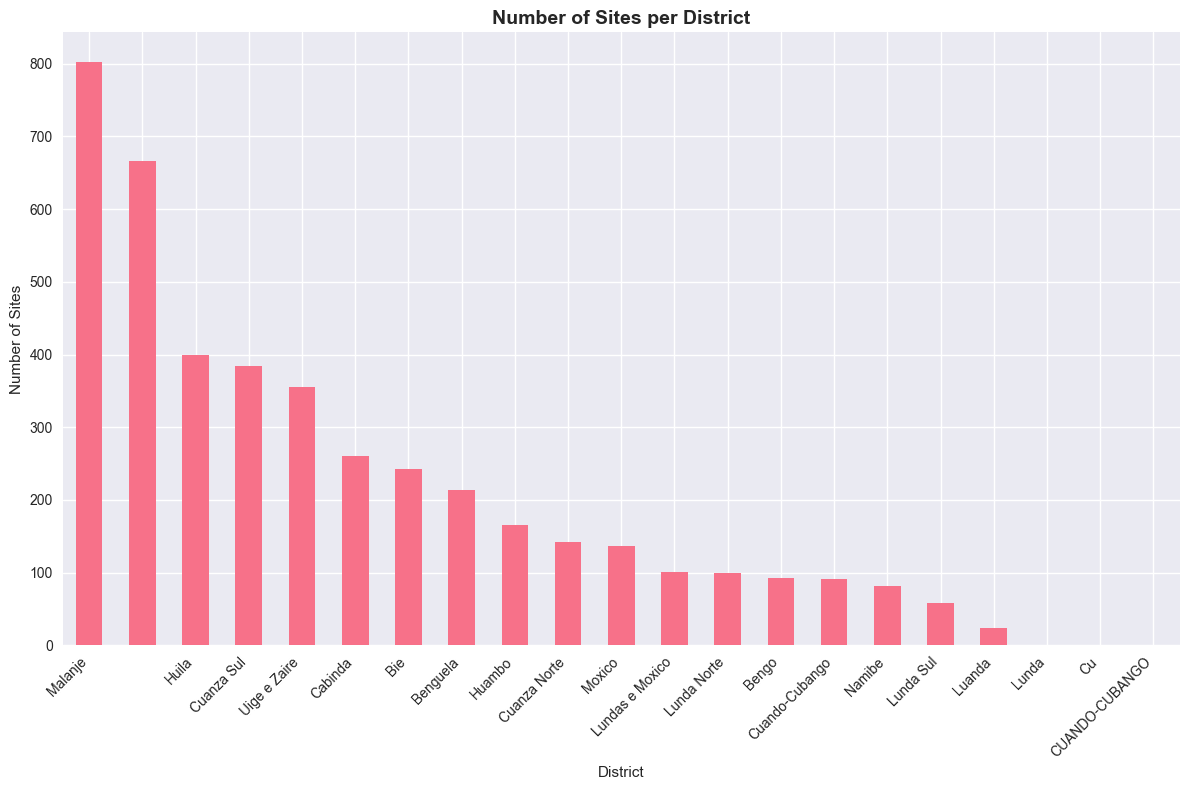

In [6]:
# === 2. GEOGRAPHIC DISTRIBUTION ANALYSIS ===
print(f"\n🌍 GEOGRAPHIC DISTRIBUTION")
print("-" * 30)

# # Sites per country
# #print total sites (all the sites are in Angola)
    
#     # Plot sites per country
#     plt.figure(figsize=(10, 6))
#     country_counts.plot(kind='bar')
#     plt.title('Number of Sites per Country', fontsize=14, fontweight='bold')
#     plt.xlabel('Country')
#     plt.ylabel('Number of Sites')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# Sites per district/region
region_cols = ['district']  # Check which column exists
region_col = None
for col in region_cols:
    if col in site_info.columns:
        region_col = col
        break

if region_col:
    print(f"\n🏘️ Sites per {region_col.title()}:")
    region_counts = site_info[region_col].value_counts()
    print(f"Total {region_col}s: {len(region_counts)}")
    print("\nTop 10:")
    print(region_counts.head(10))
    
    # Plot top regions
    plt.figure(figsize=(12, 8))
    top_regions = region_counts.head(21)
    top_regions.plot(kind='bar')
    plt.title(f'Number of Sites per {region_col.title()}', fontsize=14, fontweight='bold')
    plt.xlabel(region_col.title())
    plt.ylabel('Number of Sites')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [9]:
# === 4. WORKING SAMPLES ANALYSIS ===
print(f"\n🧪 WORKING SAMPLES ANALYSIS")
print("-" * 30)

# Samples with analysis data per region
if region_col and region_col in merged_final.columns:
    working_samples = merged_final[merged_final['analysis_id'].notna()]
    
    if len(working_samples) > 0:
        samples_per_region = working_samples[region_col].value_counts()
        
        print(f"Working samples per {region_col}:")
        print(f"Total regions with samples: {len(samples_per_region)}")
        print(f"Total working samples: {len(working_samples):,}")
        print("\nTop 10 regions by sample count:")
        print(samples_per_region.head(10))
        
        # Plot working samples per region
        plt.figure(figsize=(12, 8))
        top_sample_regions = samples_per_region.head(15)
        bars = plt.bar(range(len(top_sample_regions)), top_sample_regions.values)
        plt.title(f'Working Samples per {region_col.title()} (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel(region_col.title())
        plt.ylabel('Number of Working Samples')
        plt.xticks(range(len(top_sample_regions)), top_sample_regions.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(top_sample_regions.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


🧪 WORKING SAMPLES ANALYSIS
------------------------------


In [25]:
# === 3. CREATE MERGED DATASET ===
print(f"\n🔄 CREATING MERGED DATASET")
print("-" * 30)

# Define columns to select from each table
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth', 
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth'
]


# Select available columns from analyses
analyses_subset = analyses[analyses_cols].copy()

# Get all columns from morpho and site_info
morpho_all = morpho.copy()
site_info_all = site_info.copy()

print(f"\nDataset sizes before merging:")
print(f"  analyses subset: {len(analyses_subset):,} rows")
print(f"  morpho: {len(morpho_all):,} rows") 
print(f"  site_info: {len(site_info_all):,} rows")

# First, combine analyses and morpho data by profile
print("\n🔗 Step 1: Combining analyses and morpho data by profile...")

# Get unique profiles that exist in both analyses and morpho (for inner join behavior)
analyses_profiles = set(analyses_subset['profile'].dropna()) if 'profile' in analyses_subset.columns else set()
morpho_profiles = set(morpho_all['profile'].dropna()) if 'profile' in morpho_all.columns else set()
site_info_profiles = set(site_info_all['profile'].dropna()) if 'profile' in site_info_all.columns else set()

print(f"  Profiles in analyses: {len(analyses_profiles):,}")
print(f"  Profiles in morpho: {len(morpho_profiles):,}")
print(f"  Profiles in site_info: {len(site_info_profiles):,}")

# Find profiles that exist in site_info (our target for inner join)
valid_profiles = site_info_profiles

# Filter datasets to only include profiles that exist in site_info
analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)] if 'profile' in analyses_subset.columns else pd.DataFrame()
morpho_filtered = morpho_all[morpho_all['profile'].isin(valid_profiles)] if 'profile' in morpho_all.columns else pd.DataFrame()

print(f"  Filtered analyses (with valid profiles): {len(analyses_filtered):,} rows")
print(f"  Filtered morpho (with valid profiles): {len(morpho_filtered):,} rows")

# Combine analyses and morpho data
print("\n🔗 Step 2: Combining filtered analyses and morpho...")
if len(analyses_filtered) > 0 and len(morpho_filtered) > 0:
    # Outer join to get all data from both tables for the valid profiles
    combined_data = pd.merge(analyses_filtered, morpho_filtered, on='profile', how='outer', suffixes=('_analyses', '_morpho'))
    print(f"  Combined analyses + morpho: {len(combined_data):,} rows")
elif len(analyses_filtered) > 0:
    combined_data = analyses_filtered.copy()
    print(f"  Using analyses data only: {len(combined_data):,} rows")
elif len(morpho_filtered) > 0:
    combined_data = morpho_filtered.copy()  
    print(f"  Using morpho data only: {len(combined_data):,} rows")
else:
    combined_data = pd.DataFrame()
    print("  ⚠️  No data to combine - no valid profiles found")

# Step 3: Inner join with site_info
print(f"\n🔗 Step 3: Inner join with site_info on profile...")
if len(combined_data) > 0 and 'profile' in combined_data.columns:
    merged_final = pd.merge(combined_data, site_info_all, on='profile', how='inner')
    print(f"  Final merged dataset: {len(merged_final):,} rows")
    
    # Verify inner join success
    unique_profiles_final = merged_final['profile'].nunique()
    print(f"  Unique profiles in final dataset: {unique_profiles_final:,}")
    print(f"  All records have site_info: ✅ (inner join ensures this)")
    
else:
    print("  ⚠️  Cannot perform inner join - no combined data or missing profile column")
    merged_final = pd.DataFrame()

if len(merged_final) > 0:
    print(f"\nFinal merged dataset: {len(merged_final):,} rows × {merged_final.shape[1]} columns")
    print("✅ Successfully created dataset with site_info for all records")
else:
    print("\n❌ Failed to create merged dataset")


🔄 CREATING MERGED DATASET
------------------------------

Dataset sizes before merging:
  analyses subset: 7,763 rows
  morpho: 10,434 rows
  site_info: 4,321 rows

🔗 Step 1: Combining analyses and morpho data by profile...
  Profiles in analyses: 1,579
  Profiles in morpho: 2,218
  Profiles in site_info: 4,321
  Filtered analyses (with valid profiles): 7,763 rows
  Filtered morpho (with valid profiles): 10,434 rows

🔗 Step 2: Combining filtered analyses and morpho...
  Combined analyses + morpho: 39,656 rows

🔗 Step 3: Inner join with site_info on profile...
  Final merged dataset: 39,656 rows
  Unique profiles in final dataset: 2,302
  All records have site_info: ✅ (inner join ensures this)

Final merged dataset: 39,656 rows × 56 columns
✅ Successfully created dataset with site_info for all records


In [26]:
merged_final.columns

Index(['analysis_id', 'morpho_id_analyses', 'sample_id_analyses', 'profile',
       'depth', 'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15',
       'free_iron', 'organic_carbon', 'p205', 'organic_material', 'ph_h2o',
       'ph_kcl', 'exchangable_bases_sum', 'cec', 'sample_depth',
       'morpho_id_morpho', 'sample_id_morpho', 'horizon_layer', 'upper_depth',
       'lower_depth', 'moisture_degree', 'root_quantity', 'root_diameter',
       'texture', 'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom'],
      dtype='object')


🧪 WORKING SAMPLES ANALYSIS
------------------------------
Working samples per district:
Total districts with samples: 18
Total working samples: 36,162

Top 10 districts by sample count:
district
Malanje            7532
Uige e Zaire       4999
Cuanza Sul         3825
Huila              3710
Benguela           2966
Lundas e Moxico    2789
Cabinda            2631
Huambo             2091
Bie                2042
Cuando-Cubango     1620
Name: count, dtype: int64


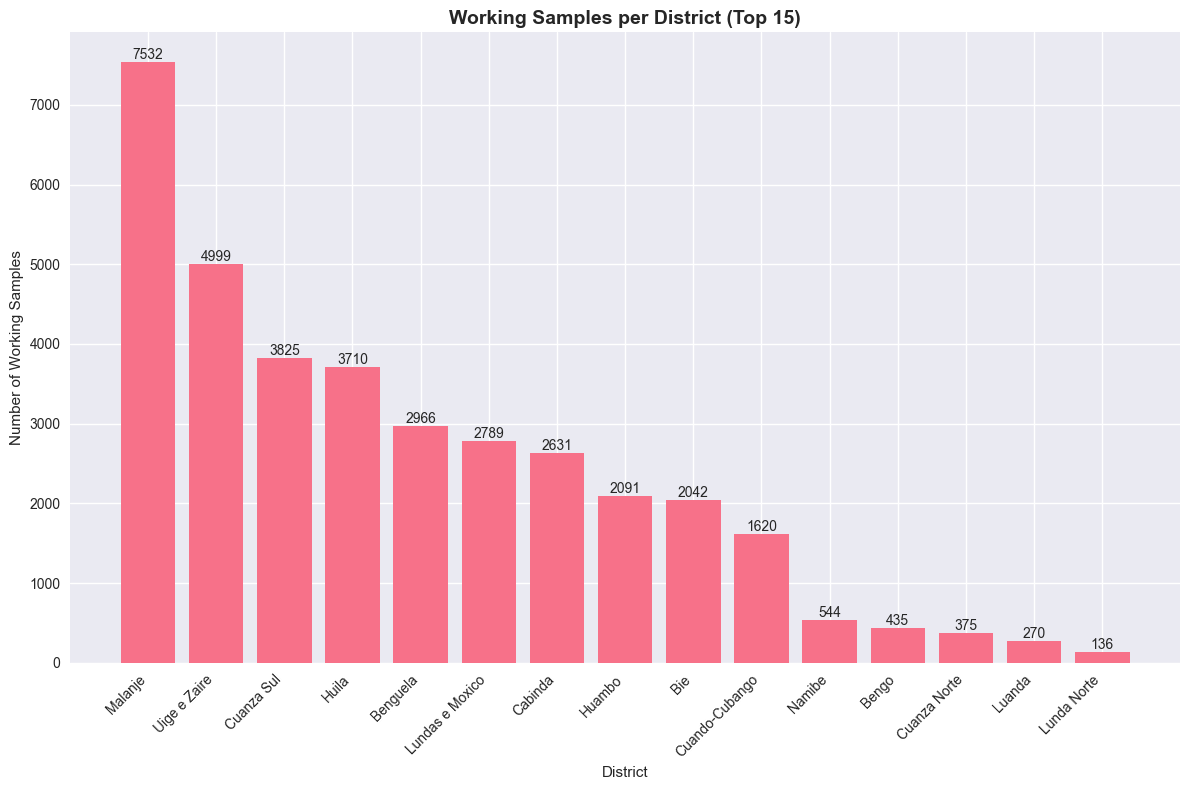

In [20]:
# === 4. WORKING SAMPLES ANALYSIS ===
print(f"\n🧪 WORKING SAMPLES ANALYSIS")
print("-" * 30)

# Samples with analysis data per district
if 'district' in merged_final.columns:
    working_samples = merged_final[merged_final['analysis_id'].notna()]
    
    if len(working_samples) > 0:
        samples_per_district = working_samples['district'].value_counts()
        
        print(f"Working samples per district:")
        print(f"Total districts with samples: {len(samples_per_district)}")
        print(f"Total working samples: {len(working_samples):,}")
        print("\nTop 10 districts by sample count:")
        print(samples_per_district.head(10))
        
        # Plot working samples per district
        plt.figure(figsize=(12, 8))
        top_sample_districts = samples_per_district.head(15)
        bars = plt.bar(range(len(top_sample_districts)), top_sample_districts.values)
        plt.title('Working Samples per District (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel('District')
        plt.ylabel('Number of Working Samples')
        plt.xticks(range(len(top_sample_districts)), top_sample_districts.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(top_sample_districts.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


🏔️ SOIL HORIZON ANALYSIS
------------------------------
Horizon layers analysis:
  Total profiles: 2,302
  Average horizons per site: 17.23
  Median horizons per site: 15
  Min horizons: 1
  Max horizons: 72

Distribution of horizons per site:
1       8
2      47
3     105
4     152
5     278
6     214
7      52
8      50
9      96
10     36
Name: count, dtype: int64


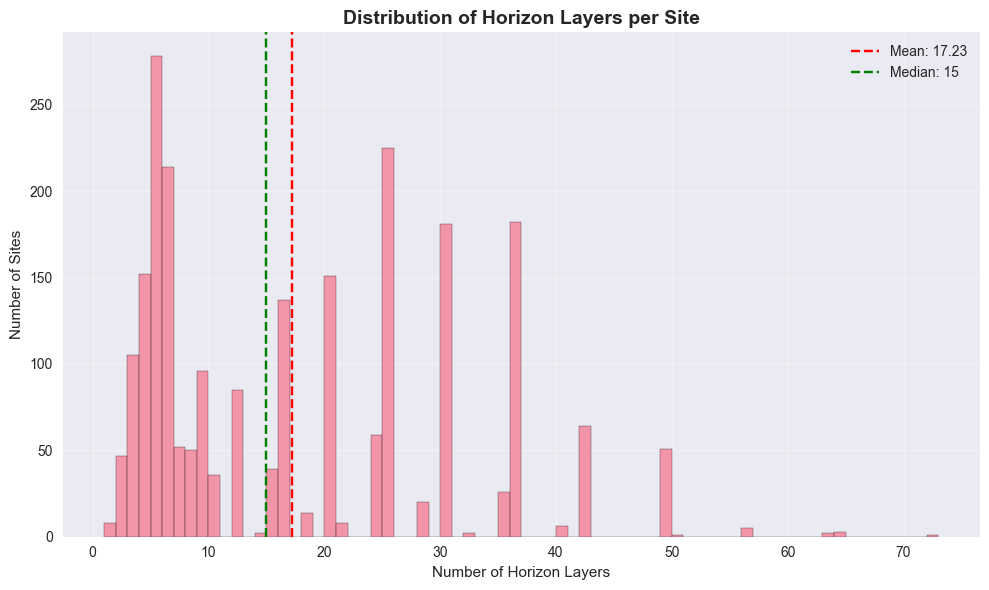

In [21]:
# === 5. HORIZON ANALYSIS ===
print(f"\n🏔️ SOIL HORIZON ANALYSIS")
print("-" * 30)

# Group by profile to analyze horizons per site
profile_col = 'profile'
if profile_col in merged_final.columns:
    # Count horizons per profile/site
    horizons_per_site = merged_final.groupby(profile_col).size()
    
    print(f"Horizon layers analysis:")
    print(f"  Total profiles: {len(horizons_per_site):,}")
    print(f"  Average horizons per site: {horizons_per_site.mean():.2f}")
    print(f"  Median horizons per site: {horizons_per_site.median():.0f}")
    print(f"  Min horizons: {horizons_per_site.min()}")
    print(f"  Max horizons: {horizons_per_site.max()}")
    
    print(f"\nDistribution of horizons per site:")
    horizon_distribution = horizons_per_site.value_counts().sort_index()
    print(horizon_distribution.head(10))
    
    # Plot histogram of horizons per site
    plt.figure(figsize=(10, 6))
    plt.hist(horizons_per_site, bins=range(1, horizons_per_site.max() + 2), 
             edgecolor='black', alpha=0.7)
    plt.title('Distribution of Horizon Layers per Site', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Horizon Layers')
    plt.ylabel('Number of Sites')
    plt.grid(True, alpha=0.3)
    
    # Add statistics text
    plt.axvline(horizons_per_site.mean(), color='red', linestyle='--', 
                label=f'Mean: {horizons_per_site.mean():.2f}')
    plt.axvline(horizons_per_site.median(), color='green', linestyle='--', 
                label=f'Median: {horizons_per_site.median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
merged_final.columns

Index(['analysis_id', 'morpho_id_analyses', 'sample_id_analyses', 'profile',
       'depth', 'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15',
       'free_iron', 'organic_carbon', 'p205', 'organic_material', 'ph_h2o',
       'ph_kcl', 'exchangable_bases_sum', 'cec', 'morpho_id_morpho',
       'sample_id_morpho', 'horizon_layer', 'upper_depth', 'lower_depth',
       'moisture_degree', 'root_quantity', 'root_diameter', 'texture',
       'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom'],
      dtype='object')


📏 DEPTH ANALYSIS
------------------------------
Depth analysis (using 'sample_depth'):
  Total depth measurements: 36,162
  Depth range: -70.0 to 131.0
  Mean depth: 25.6
  Median depth: 26.0


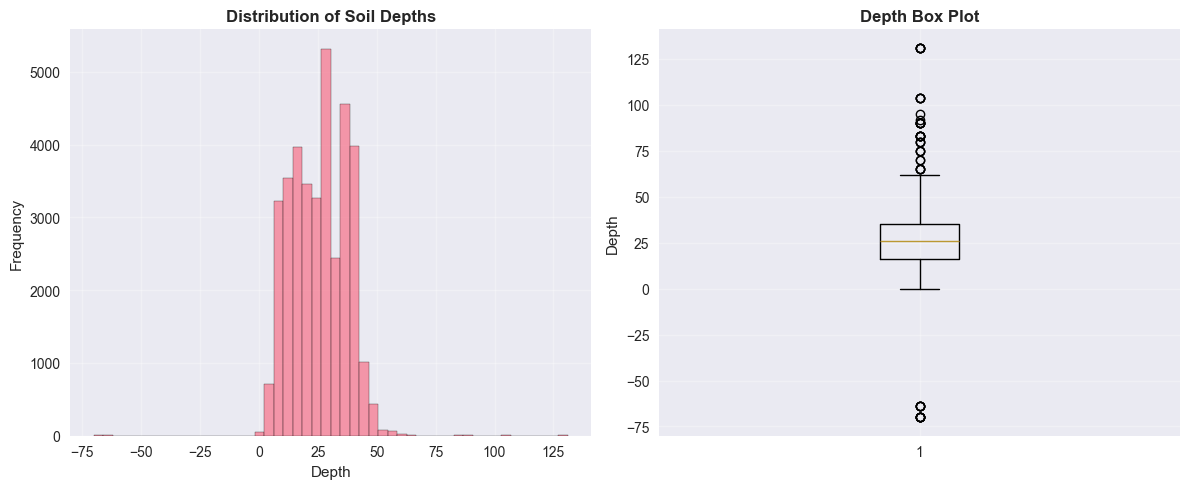

In [27]:
# === 6. DEPTH ANALYSIS ===
print(f"\n📏 DEPTH ANALYSIS")
print("-" * 30)

# Define the depth column you want to use
depth_col = 'sample_depth'

if depth_col in merged_final.columns:
    depths = merged_final[depth_col].dropna()

    if len(depths) > 0:
        print(f"Depth analysis (using '{depth_col}'):")
        print(f"  Total depth measurements: {len(depths):,}")
        print(f"  Depth range: {depths.min():.1f} to {depths.max():.1f}")
        print(f"  Mean depth: {depths.mean():.1f}")
        print(f"  Median depth: {depths.median():.1f}")
        
        # Plot depth distribution
        plt.figure(figsize=(12, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(depths, bins=50, edgecolor='black', alpha=0.7)
        plt.title('Distribution of Soil Depths', fontsize=12, fontweight='bold')
        plt.xlabel('Depth')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Boxplot
        plt.subplot(1, 2, 2)
        plt.boxplot(depths)
        plt.title('Depth Box Plot', fontsize=12, fontweight='bold')
        plt.ylabel('Depth')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid values found in '{depth_col}'.")
else:
    print(f"Column '{depth_col}' not found in DataFrame.")


In [23]:
# === 7. HORIZON DESIGNATION ANALYSIS ===
print(f"\n🔤 HORIZON DESIGNATION ANALYSIS")
print("-" * 30)

horizon_cols = ['horizon', 'horizon_designation', 'layer', 'layer_designation']
available_horizon_cols = [col for col in horizon_cols if col in merged_final.columns]

if available_horizon_cols:
    horizon_col = available_horizon_cols[0]
    horizons = merged_final[horizon_col].dropna()
    
    if len(horizons) > 0:
        horizon_counts = horizons.value_counts()
        print(f"Horizon designation analysis (using {horizon_col}):")
        print(f"  Total horizon designations: {len(horizons):,}")
        print(f"  Unique designations: {len(horizon_counts)}")
        print(f"\nTop 15 horizon designations:")
        print(horizon_counts.head(15))
        
        # Plot horizon designations
        plt.figure(figsize=(14, 8))
        top_horizons = horizon_counts.head(20)
        bars = plt.bar(range(len(top_horizons)), top_horizons.values)
        plt.title('Most Common Horizon Designations', fontsize=14, fontweight='bold')
        plt.xlabel('Horizon Designation')
        plt.ylabel('Count')
        plt.xticks(range(len(top_horizons)), top_horizons.index, rotation=45, ha='right')
        
        # Add value labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    str(top_horizons.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Classify depth by horizon designation
        if depth_col in merged_final.columns:
            horizon_depth = merged_final.groupby(horizon_col)[depth_col].agg(['mean', 'median', 'std', 'count']).round(2)
            horizon_depth = horizon_depth.sort_values('mean')
            
            print(f"\nDepth statistics by horizon designation (top 15):")
            print(horizon_depth.head(15))


🔤 HORIZON DESIGNATION ANALYSIS
------------------------------


In [28]:

# === 7. HORIZON DESIGNATION ANALYSIS ===
# Check columns exist
required_cols = ['profile', 'horizon_layer', 'sample_depth', 'upper_depth', 'lower_depth']
missing_cols = [col for col in required_cols if col not in merged_final.columns]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
else:
    # Drop rows with missing depth info to avoid errors
    df = merged_final.dropna(subset=['profile', 'horizon_layer', 'upper_depth', 'lower_depth'])

    # Group by profile
    horizon_summary = df.groupby('profile').agg(
        num_horizons = ('horizon_layer', 'nunique'),             # count unique horizons
        min_depth = ('upper_depth', 'min'),                      # shallowest start
        max_depth = ('lower_depth', 'max'),                      # deepest end
        total_thickness = ('sample_depth', 'sum')                # sum thickness of horizons
    ).reset_index()

    print(horizon_summary)

    # Optional: Show profiles with their number of horizons and depth range nicely
    for _, row in horizon_summary.iterrows():
        print(f"Profile {row['profile']}: {row['num_horizons']} horizons, depth range {row['min_depth']} - {row['max_depth']} cm, total thickness {row['total_thickness']:.1f} cm")


      profile  num_horizons  min_depth  max_depth  total_thickness
0     100C_62             6        0.0      180.0              0.0
1     100C_63             5        0.0      165.0              0.0
2      100_56             4        0.0      190.0            500.0
3      100_58             4        0.0      110.0            468.0
4      100_59             3        0.0       67.0            201.0
...       ...           ...        ...        ...              ...
2213    9C_60             6        0.0      170.0            888.0
2214    9C_63             5        0.0      170.0            625.0
2215     9_59             4        0.0      100.0              0.0
2216     9_62             5        0.0      175.0            625.0
2217     9_63             5        0.0       90.0            450.0

[2218 rows x 5 columns]
Profile 100C_62: 6 horizons, depth range 0.0 - 180.0 cm, total thickness 0.0 cm
Profile 100C_63: 5 horizons, depth range 0.0 - 165.0 cm, total thickness 0.0 cm
Profile 100


Summary Statistics:
       num_horizons    min_depth    max_depth  total_thickness
count   2218.000000  2218.000000  2218.000000      2218.000000
mean       4.698377     0.120153   145.093327       413.403517
std        1.283674     2.966375    43.466149       378.331108
min        1.000000     0.000000     8.000000         0.000000
25%        4.000000     0.000000   115.000000         0.000000
50%        5.000000     0.000000   165.000000       368.000000
75%        6.000000     0.000000   175.000000       715.000000
max        9.000000   116.000000   280.000000      1722.000000


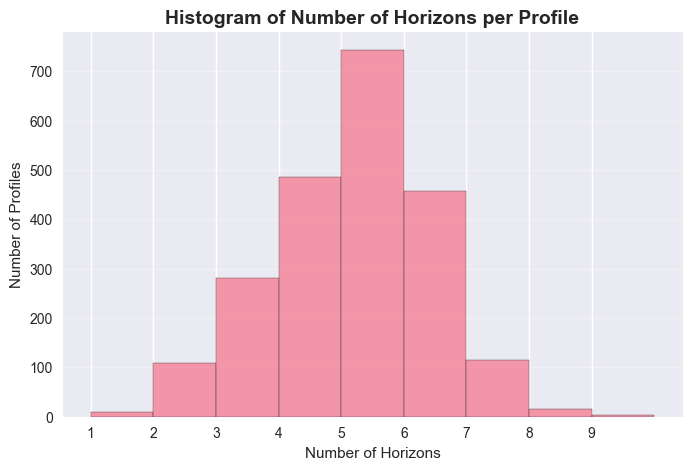

In [29]:
import matplotlib.pyplot as plt

# Assuming `horizon_summary` is the DataFrame from before

# Summary statistics for numeric columns
summary_stats = horizon_summary.describe()
print("\nSummary Statistics:")
print(summary_stats[['num_horizons', 'min_depth', 'max_depth', 'total_thickness']])

# Histogram for number of horizons per profile
plt.figure(figsize=(8,5))
plt.hist(horizon_summary['num_horizons'], bins=range(1, horizon_summary['num_horizons'].max() + 2), 
         edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Horizons per Profile', fontsize=14, fontweight='bold')
plt.xlabel('Number of Horizons')
plt.ylabel('Number of Profiles')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(1, horizon_summary['num_horizons'].max() + 1))
plt.show()

In [ ]:
#General EDA questions
# what is it? graphical output and descriptive statistics for our data

#ABOUT THE DATA
# How many sites per country
# how many sites per district
# do I need to break into even more specific site groupings

# histogram of sites per region
# histogram of working samples per region

# How many horizon layers per site
# depth range of horizon layers
# classify depth by its soil horizon designation

# generalize horizon labels --find out if any python package/function can set horizon label basd

#crosstabulate
## soil designation (taxonomic group and particle size)

#Pattern matching
## variation of particle size classes are within a specific subgroup (like a specific soil horizon)
## pattern match on taxonomic group, geomorphology or parent material

# filtering

# common landforms in area, commanalities in climate, 
    ## parent material, taxonomic history, geomorphic data, ecological site history (?) useful



In [ ]:
## Descriptive statistics
# mean, medium, and mode clay, sand, silt content
# number of observations for each horizon, for each site